# LSTM Model training and testing

In [1]:
!pip install conllu

import torch,torchtext
from conllu import parse_incr
import glob
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/MyDrive/NLP_Assignment_2/UD_English-Atis'
data = {}
for file in glob.glob(data_path+"/*.conllu"):
  type_of_data = file.split("/")[-1].split(".")[0].split("-")[-1]
  data_file = open(file,'r',encoding='utf8')
  data_t = parse_incr(data_file)
  data[type_of_data] = [([word['form'] for word in sentence],[word['upos'] for word in sentence]) for sentence in data_t]
  print(type_of_data,'extracted!')

train_words, train_labels = [], []
for words, labels in data['train']:
  for word, label in zip(words, labels) :
    train_words.append(word)
    train_labels.append(label)

for data_type in ['dev','test']:
  temp_data=[]
  for words, labels in data[data_type]:
    flag = 0
    for label in labels:
      if label not in train_labels:
        flag = 1
    if flag == 0:
      temp_data.append((words,labels))
  data[data_type] = temp_data
  print("removed labels from",data_type,"not in train ")


dev extracted!
test extracted!
train extracted!
removed labels from dev not in train 
removed labels from test not in train 


In [4]:
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

class LSTMDataset(Dataset):
  def __init__(self, data: list[tuple[list[str], list[int]]], vocabulary_words:Vocab|None=None, vocabulary_tags:Vocab|None=None):
    """Initialize the dataset. Setup Code goes here"""
    self.sentences = [i[0] for i in data]
    self.word_labels = [i[1] for i in data]

    if vocabulary_words is None:
      self.vocabulary_words = build_vocab_from_iterator(self.sentences, specials=[START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PAD_TOKEN])
      self.vocabulary_words.set_default_index(self.vocabulary_words[UNKNOWN_TOKEN])
    else:
      self.vocabulary_words = vocabulary_words

    if vocabulary_tags is None:
      self.vocabulary_tags = build_vocab_from_iterator(self.word_labels, specials=[PAD_TOKEN])
    else:
      self.vocabulary_tags = vocabulary_tags

  def __len__(self) -> int:
    """Returns number of datapoints."""
    return len(self.sentences)

  def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
    """Get the datapoint at `index`."""
    return torch.tensor(self.vocabulary_words.lookup_indices(self.sentences[index])), torch.tensor(self.vocabulary_tags.lookup_indices(self.word_labels[index]))

  def collate(self, batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
    """Given a list of datapoints, batch them together"""
    sentences = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=self.vocabulary_words[PAD_TOKEN])
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=self.vocabulary_tags[PAD_TOKEN])
    return padded_sentences, padded_labels


In [ ]:
dataset_train = LSTMDataset(data['train'])
dataset_eval = LSTMDataset(data['dev'], vocabulary_words=dataset_train.vocabulary_words, vocabulary_tags=dataset_train.vocabulary_tags)
dataset_test = LSTMDataset(data['test'],vocabulary_words=dataset_train.vocabulary_words, vocabulary_tags=dataset_train.vocabulary_tags)

In [ ]:
file_path = '/content/drive/MyDrive/NLP_Assignment_2/lstm_vocab.pkl'
with open(file_path, 'wb') as f:
    pickle.dump([dataset_train.vocabulary_words, dataset_train.vocabulary_tags],  f)

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True, collate_fn=dataset_train.collate)
val_dataloader = DataLoader(dataset_eval, batch_size=64, collate_fn=dataset_eval.collate)
test_dataloader = DataLoader(dataset_test, batch_size=64, collate_fn=dataset_eval.collate)

In [ ]:
for ip, op in train_dataloader:
  print(ip.shape,op.shape)
  break

torch.Size([64, 23]) torch.Size([64, 23])


In [5]:
class LSTMModel(torch.nn.Module):
    def __init__(self, vocab_size, num_classes, hidden_size, num_layers, bidirectionality=False, embedding_dim=256):
        super(LSTMModel, self).__init__()
        self.bidirectionality = bidirectionality
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=self.bidirectionality)
        if self.bidirectionality:
          self.fc = torch.nn.Linear(hidden_size*2, num_classes)
        else:
          self.fc = torch.nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.lstm(embedded)
        out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, score, model):

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score < self.best_score - self.delta:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, score, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
def train_lstm(model, model_name, n_epochs=30):
  val_accuracies_epoch_wise = []
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("Utilising",device)
  loss_fn = torch.nn.CrossEntropyLoss(ignore_index=dataset_train.vocabulary_tags[PAD_TOKEN])
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  model = model.to(device)
  model_path = '/content/drive/MyDrive/NLP_Assignment_2/Models/LSTM_'+model_name+".pt"
  early_stopping = EarlyStopping(patience=5, path=model_path)

  for epoch_num in range(n_epochs):
      model.train()
      epoch_loss = 0

      progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_num}", total=len(train_dataloader))

      for batch_num, (words, tags) in enumerate(progress_bar):
          (words, tags) = (words.to(device), tags.to(device))
          pred = model(words)
          loss = loss_fn(pred.view(-1, pred.shape[-1]), tags.view(-1))
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          epoch_loss += loss.item()
          progress_bar.set_postfix({'loss': loss.item()})

      epoch_loss /= len(train_dataloader)
      model.eval()

      with torch.no_grad():
        all_predictions = []
        all_ground_truth = []
        val_loss = 0
        for batch_num, (words, tags) in enumerate(val_dataloader):
            (words, tags) = (words.to(device), tags.to(device))
            pred = model(words)
            val_loss += loss_fn(pred.view(-1, pred.shape[-1]), tags.view(-1)).item()
            predictions = torch.argmax(pred, axis=-1).cpu().numpy().flatten()
            ground_truth = tags.cpu().numpy().flatten()
            all_predictions.append(predictions)
            all_ground_truth.append(ground_truth)
        all_predictions = np.concatenate(all_predictions)
        all_ground_truth = np.concatenate(all_ground_truth)

        non_pad_indices = (all_ground_truth != dataset_train.vocabulary_tags[PAD_TOKEN])
        all_predictions = all_predictions[non_pad_indices]
        all_ground_truth = all_ground_truth[non_pad_indices]

        accuracy_val = accuracy_score(all_ground_truth, all_predictions)
        val_accuracies_epoch_wise.append(accuracy_val)
        val_loss /= len(val_dataloader)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping....")
            break

      if epoch_num % 1 == 0:
          print(f"Epoch {epoch_num}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
  print("best val loss is",early_stopping.best_score)
  return val_accuracies_epoch_wise

def test_lstm(model, model_name):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("Utilising",device)
  model = model.to(device)
  model_path = '/content/drive/MyDrive/NLP_Assignment_2/Models/LSTM_'+model_name+".pt"
  state_dict = torch.load(model_path)
  model.load_state_dict(state_dict)
  model.eval()

  with torch.no_grad():
    all_predictions = []
    all_ground_truth = []
    for batch_num, (words, tags) in enumerate(val_dataloader):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        predictions = torch.argmax(pred, axis=-1).cpu().numpy().flatten()
        ground_truth = tags.cpu().numpy().flatten()
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
    all_predictions = np.concatenate(all_predictions)
    all_ground_truth = np.concatenate(all_ground_truth)

    non_pad_indices = (all_ground_truth != dataset_train.vocabulary_tags[PAD_TOKEN])
    all_predictions = all_predictions[non_pad_indices]
    all_ground_truth = all_ground_truth[non_pad_indices]

    accuracy_val = accuracy_score(all_ground_truth, all_predictions)

    all_predictions = []
    all_ground_truth = []
    for batch_num, (words, tags) in enumerate(test_dataloader):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        predictions = torch.argmax(pred, axis=-1).cpu().numpy().flatten()
        ground_truth = tags.cpu().numpy().flatten()
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
    all_predictions = np.concatenate(all_predictions)
    all_ground_truth = np.concatenate(all_ground_truth)

    non_pad_indices = (all_ground_truth != dataset_train.vocabulary_tags[PAD_TOKEN])
    all_predictions = all_predictions[non_pad_indices]
    all_ground_truth = all_ground_truth[non_pad_indices]

    accuracy_test = accuracy_score(all_ground_truth, all_predictions)

    return accuracy_val, accuracy_test


In [6]:
model_configs_lstm = {
    'model_1':{
        'hidden_layers':10,
        'hidden_dim':256,
        'embedding_size':128,
        'bidirectionality':True
    },
    'model_2':{
        'hidden_layers':7,
        'hidden_dim':256,
        'embedding_size':256,
        'bidirectionality':False
        },
    'model_3':{
        'hidden_layers':5,
        'hidden_dim':512,
        'embedding_size':512,
        'bidirectionality':True
    }
}

In [ ]:
model_performace = {}
for model_name in model_configs_lstm:
  print("Training",model_name)
  hidden_dim = model_configs_lstm[model_name]['hidden_dim']
  hidden_layers = model_configs_lstm[model_name]['hidden_layers']
  embedding_dim = model_configs_lstm[model_name]['embedding_size']
  bidirectionality = model_configs_lstm[model_name]['bidirectionality']
  model = LSTMModel(len(dataset_train.vocabulary_words), len(dataset_train.vocabulary_tags), hidden_dim, hidden_layers,bidirectionality=bidirectionality, embedding_dim=embedding_dim)
  val_accuracy_epoch_wise = train_lstm(model, model_name, n_epochs=30)
  accuracy_val, accuracy_test = test_lstm(model, model_name)
  model_performace[model_name] = {'val_accuracy_epoch_wise':val_accuracy_epoch_wise, 'val_accuracy':accuracy_val, 'test_accuracy':accuracy_test}

Training model_1
Utilising cuda


Epoch 0:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 0, Train Loss: 1.8437, Val Loss: 1.6532


Epoch 1:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.5210, Val Loss: 1.4459


Epoch 2:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2, Train Loss: 1.2000, Val Loss: 0.7415


Epoch 3:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.5449, Val Loss: 0.4088


Epoch 4:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.3362, Val Loss: 0.3028


Epoch 5:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.2620, Val Loss: 0.2538


Epoch 6:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.2023, Val Loss: 0.2123


Epoch 7:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.1622, Val Loss: 0.1883


Epoch 8:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.1431, Val Loss: 0.1893


Epoch 9:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.1348, Val Loss: 0.1731


Epoch 10:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.1151, Val Loss: 0.1794


Epoch 11:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.1016, Val Loss: 0.1694


Epoch 12:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0908, Val Loss: 0.1552


Epoch 13:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0802, Val Loss: 0.1461


Epoch 14:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0735, Val Loss: 0.1590


Epoch 15:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.0668, Val Loss: 0.1374


Epoch 16:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0651, Val Loss: 0.1525


Epoch 17:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.0613, Val Loss: 0.1456


Epoch 18:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0845, Val Loss: 0.2051


Epoch 19:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0806, Val Loss: 0.1502


Epoch 20:   0%|          | 0/67 [00:00<?, ?it/s]

Early stopping....
best val loss is 0.1373923292590512
Utilising cuda
Training model_2
Utilising cuda


Epoch 0:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 0, Train Loss: 1.9512, Val Loss: 1.7709


Epoch 1:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1, Train Loss: 1.6399, Val Loss: 1.4956


Epoch 2:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.9611, Val Loss: 0.6676


Epoch 3:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.4998, Val Loss: 0.4185


Epoch 4:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.3279, Val Loss: 0.3091


Epoch 5:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.2420, Val Loss: 0.2609


Epoch 6:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.1947, Val Loss: 0.2381


Epoch 7:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.1780, Val Loss: 0.2128


Epoch 8:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.1438, Val Loss: 0.1974


Epoch 9:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.1358, Val Loss: 0.2133


Epoch 10:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.1362, Val Loss: 0.1864


Epoch 11:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.1130, Val Loss: 0.1742


Epoch 12:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.1027, Val Loss: 0.1743


Epoch 13:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0951, Val Loss: 0.1670


Epoch 14:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0947, Val Loss: 0.1638


Epoch 15:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.0935, Val Loss: 0.1725


Epoch 16:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0891, Val Loss: 0.1688


Epoch 17:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.0869, Val Loss: 0.1690


Epoch 18:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0952, Val Loss: 0.1591


Epoch 19:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0836, Val Loss: 0.1599


Epoch 20:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0796, Val Loss: 0.1559


Epoch 21:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.0726, Val Loss: 0.1613


Epoch 22:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.0716, Val Loss: 0.1538


Epoch 23:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.0687, Val Loss: 0.1598


Epoch 24:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.0683, Val Loss: 0.1574


Epoch 25:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.0661, Val Loss: 0.1598


Epoch 26:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.0655, Val Loss: 0.1533


Epoch 27:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.0661, Val Loss: 0.1546


Epoch 28:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.0680, Val Loss: 0.1737


Epoch 29:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.0658, Val Loss: 0.1520
best val loss is 0.15201690875821644
Utilising cuda
Training model_3
Utilising cuda


Epoch 0:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.9368, Val Loss: 0.1749


Epoch 1:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.1019, Val Loss: 0.0709


Epoch 2:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.0591, Val Loss: 0.0745


Epoch 3:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.0485, Val Loss: 0.0688


Epoch 4:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.0414, Val Loss: 0.0672


Epoch 5:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.0334, Val Loss: 0.0695


Epoch 6:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.0317, Val Loss: 0.0773


Epoch 7:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.0295, Val Loss: 0.0778


Epoch 8:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.0267, Val Loss: 0.0957


Epoch 9:   0%|          | 0/67 [00:00<?, ?it/s]

Early stopping....
best val loss is 0.06721094333463246
Utilising cuda


In [ ]:
import pickle
file_path = '/content/drive/MyDrive/NLP_Assignment_2/model_performace_lstm.pkl'

with open(file_path, 'wb') as f:
    pickle.dump(model_performace, f)

print("Dictionary saved as pickle file:", file_path)

Dictionary saved as pickle file: /content/drive/MyDrive/NLP_Assignment_2/model_performace_lstm.pkl


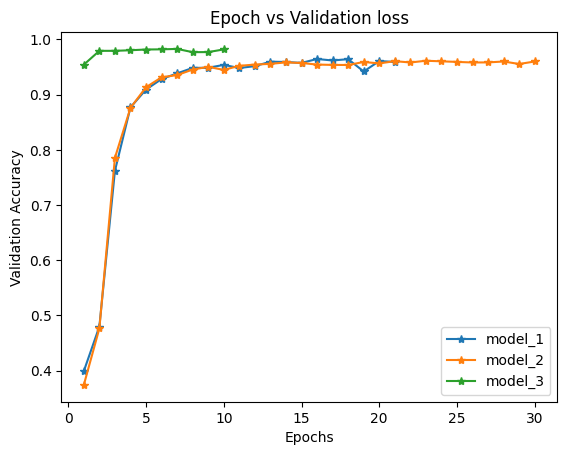

In [ ]:
import matplotlib.pyplot as plt
for model in model_performace:
  val_accuracies = model_performace[model]['val_accuracy_epoch_wise']
  plt.plot(range(1,len(val_accuracies)+1), val_accuracies,marker='*',label=model)
  plt.xlabel('Epochs')
  plt.ylabel('Validation Accuracy')
plt.legend()
plt.title("Epoch vs Validation loss")
plt.savefig('/content/drive/MyDrive/NLP_Assignment_2/Plots/LSTM.png')
plt.show()


# FFNN model training and testing

In [ ]:
data_path = '/content/drive/MyDrive/NLP_Assignment_2/UD_English-Atis'
data = {}
for file in glob.glob(data_path+"/*.conllu"):
  type_of_data = file.split("/")[-1].split(".")[0].split("-")[-1]
  data_file = open(file,'r',encoding='utf8')
  data_t = parse_incr(data_file)
  data[type_of_data] = [([word['form'] for word in sentence],[word['upos'] for word in sentence]) for sentence in data_t]
  print(type_of_data,'extracted!')

train_words, train_labels = [], []
for words, labels in data['train']:
  for word, label in zip(words, labels) :
    train_words.append(word)
    train_labels.append(label)

for data_type in ['dev','test']:
  temp_data=[]
  for words, labels in data[data_type]:
    flag = 0
    for label in labels:
      if label not in train_labels:
        flag = 1
    if flag == 0:
      temp_data.append((words,labels))
  data[data_type] = temp_data
  print("removed labels from",data_type,"not in train ")


dev extracted!
test extracted!
train extracted!
removed labels from dev not in train 
removed labels from test not in train 


In [7]:
START_TOKEN = "<s>"
END_TOKEN = "</s>"
UNKNOWN_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

class FFNNDataset(Dataset):
  def __init__(self, data: list[tuple[list[str], list[int]]], p=0, s=0, vocabulary_words:Vocab|None=None, vocabulary_tags:Vocab|None=None):
    """Initialize the dataset. Setup Code goes here"""
    self.sentences = [i[0] for i in data]
    self.word_labels = [i[1] for i in data]
    self.words = []
    self.labels = []
    for sentence, label in zip(self.sentences, self.word_labels):
      sentence = [START_TOKEN]*p + sentence + [END_TOKEN]*s
      for i in range (p, len(sentence)-s):
        start_idx, end_idx = i-p, i+s+1
        word_with_context = sentence[start_idx:end_idx]
        self.words.append(word_with_context)
        self.labels.append(label[i-p])

    if vocabulary_words is None:
      self.vocabulary_words = build_vocab_from_iterator(self.sentences, specials=[START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PAD_TOKEN])
      self.vocabulary_words.set_default_index(self.vocabulary_words[UNKNOWN_TOKEN])
    else:
      self.vocabulary_words = vocabulary_words

    if vocabulary_tags is None:
      self.vocabulary_tags = build_vocab_from_iterator(self.word_labels, specials=[PAD_TOKEN])
    else:
      self.vocabulary_tags = vocabulary_tags

  def __len__(self) -> int:
    """Returns number of datapoints."""
    return len(self.words)

  def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
    """Get the datapoint at `index`."""
    word_indices = [self.vocabulary_words[token] for token in self.words[index]]
    label_index = self.vocabulary_tags[self.labels[index]]
    return torch.tensor(word_indices), torch.tensor(label_index)

In [8]:
class FFNN(torch.nn.Module):
    def __init__(self, vocab_size, output_dim, context_size, hidden_dims, activation='relu', embedding_dim=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.embedding_dim = embedding_dim

        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.hidden_layers = torch.nn.ModuleList()
        prev_dim = embedding_dim*context_size
        for dim in hidden_dims:
            self.hidden_layers.append(torch.nn.Linear(prev_dim, dim))
            prev_dim = dim
        self.output_layer = torch.nn.Linear(prev_dim, output_dim)

        if activation == 'relu':
            self.activation_function = torch.nn.ReLU()
        elif activation == 'sigmoid':
            self.activation_function = torch.nn.Sigmoid()
        elif activation == 'tanh':
            self.activation_function = torch.nn.Tanh()

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        for layer in self.hidden_layers:
            x = self.activation_function(layer(x))
        x = self.output_layer(x)
        return x


class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, score, model):

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score < self.best_score - self.delta:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, score, model):
        torch.save(model.state_dict(), self.path)



In [ ]:
def train_ffnn(model, model_name, n_epochs=50):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("Utilising",device)
  model = model.to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  model_path = '/content/drive/MyDrive/NLP_Assignment_2/Models/'+model_name+".pt"
  early_stopping = EarlyStopping(patience=5, path=model_path)

  for epoch_num in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_num}", total=len(train_dataloader))

    for batch_num, (words, tags) in enumerate(progress_bar):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        loss = loss_fn(pred, tags)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss /= len(train_dataloader)
    model.eval()

    with torch.no_grad():
        val_loss = 0
        for batch_num, (words, tags) in enumerate(val_dataloader):
            (words, tags) = (words.to(device), tags.to(device))
            pred = model(words)
            val_loss += loss_fn(pred, tags)
        val_loss /= len(val_dataloader)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping....")
            break

    if epoch_num % 1 == 0:
        print(f"Epoch {epoch_num}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}")
  print("best val loss is",early_stopping.best_score)
  return early_stopping.best_score


def test_ffnn(model, model_name):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print("Utilising",device)
  model = model.to(device)
  model_path = '/content/drive/MyDrive/NLP_Assignment_2/Models/'+model_name+".pt"
  state_dict = torch.load(model_path)
  model.load_state_dict(state_dict)
  model.eval()

  with torch.no_grad():
    all_predictions = []
    all_ground_truth = []
    for batch_num, (words, tags) in enumerate(val_dataloader):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        predictions = torch.argmax(pred, dim=-1).cpu().numpy()
        ground_truth = tags.cpu().numpy()
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
    all_predictions = np.concatenate(all_predictions)
    all_ground_truth = np.concatenate(all_ground_truth)
    accuracy_val = accuracy_score(all_ground_truth, all_predictions)

    all_predictions = []
    all_ground_truth = []
    for batch_num, (words, tags) in enumerate(test_dataloader):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        predictions = torch.argmax(pred, dim=-1).cpu().numpy()
        ground_truth = tags.cpu().numpy()
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
    all_predictions = np.concatenate(all_predictions)
    all_ground_truth = np.concatenate(all_ground_truth)
    accuracy_test = accuracy_score(all_ground_truth, all_predictions)

    return accuracy_val, accuracy_test

In [9]:
model_configs_fnn = {
    'Model_1':{
        'hidden_dims':[512, 256, 128, 64],
        'activation':'relu',
        'embedding_size':256
    },
    'Model_2':{
        'hidden_dims':[256, 256, 128, 128],
        'activation':'tanh',
        'embedding_size':128
    },
    'Model_3':{
        'hidden_dims':[512, 512, 256, 128, 64],
        'activation':'relu',
        'embedding_size':256
    }
}

In [ ]:
model_performance = {}
for model_name in model_configs_fnn:
  print("Training",model_name)
  model_performance[model_name] = {}
  for context_length in [0,1,2,3,4]:
    s, p = context_length,context_length
    print("Training with context length",context_length)
    context_size = (context_length*2)+1
    hidden_dim = model_configs_fnn[model_name]['hidden_dims']
    activation = model_configs_fnn[model_name]['activation']
    embedding_dim = model_configs_fnn[model_name]['embedding_size']

    # Create dataset
    dataset_train = FFNNDataset(data['train'],p=p,s=s)
    dataset_eval = FFNNDataset(data['dev'],p=p,s=s, vocabulary_words=dataset_train.vocabulary_words, vocabulary_tags=dataset_train.vocabulary_tags)
    dataset_test = FFNNDataset(data['test'],p=p,s=s, vocabulary_words=dataset_train.vocabulary_words, vocabulary_tags=dataset_train.vocabulary_tags)
    # Dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(dataset_eval, batch_size=64)
    test_dataloader = DataLoader(dataset_test, batch_size=64)
    model = FFNN(len(dataset_train.vocabulary_words), len(dataset_train.vocabulary_tags), context_size,
                 hidden_dim, activation, embedding_dim=embedding_dim)
    best_val_score = train_ffnn(model, model_name+'_'+str(context_length), n_epochs=30)
    accuracy_val, accuracy_test = test_ffnn(model, model_name+'_'+str(context_length))
    model_performance[model_name][context_length] = {'best_val_loss':best_val_score, 'val_accuracy':accuracy_val, 'test_accuracy':accuracy_test}



Training Model_1
Training with context length 0
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.266301, Val Loss: 0.137034


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.119545, Val Loss: 0.134221


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.107465, Val Loss: 0.129305


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.102731, Val Loss: 0.129655


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.099002, Val Loss: 0.132756


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.098338, Val Loss: 0.126112


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.097133, Val Loss: 0.129138


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.103879, Val Loss: 0.138116


Epoch 8:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.097855, Val Loss: 0.130671


Epoch 9:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.095135, Val Loss: 0.131664


Epoch 10:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.094715, Val Loss: 0.124831


Epoch 11:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.094040, Val Loss: 0.124744


Epoch 12:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.093917, Val Loss: 0.128395


Epoch 13:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.093915, Val Loss: 0.133804


Epoch 14:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.096804, Val Loss: 0.139193


Epoch 15:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.098183, Val Loss: 0.136262


Epoch 16:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.1247, device='cuda:0')
Utilising cuda
Training with context length 1
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.219687, Val Loss: 0.112748


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.065758, Val Loss: 0.081601


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.049518, Val Loss: 0.069330


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.043791, Val Loss: 0.084895


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.038422, Val Loss: 0.090341


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.039315, Val Loss: 0.073828


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.033904, Val Loss: 0.089338


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0693, device='cuda:0')
Utilising cuda
Training with context length 2
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.236609, Val Loss: 0.101095


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.069465, Val Loss: 0.088652


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.051456, Val Loss: 0.092027


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.040456, Val Loss: 0.095179


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.037714, Val Loss: 0.109118


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.032964, Val Loss: 0.119231


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0887, device='cuda:0')
Utilising cuda
Training with context length 3
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.258853, Val Loss: 0.109064


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.069861, Val Loss: 0.121883


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.053522, Val Loss: 0.096299


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.042111, Val Loss: 0.091380


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.038480, Val Loss: 0.084021


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.031672, Val Loss: 0.109453


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.027791, Val Loss: 0.103523


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.028583, Val Loss: 0.118219


Epoch 8:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.028506, Val Loss: 0.107742


Epoch 9:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0840, device='cuda:0')
Utilising cuda
Training with context length 4
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.275666, Val Loss: 0.124314


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.073728, Val Loss: 0.109201


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.049033, Val Loss: 0.097837


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.044020, Val Loss: 0.121537


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.032796, Val Loss: 0.129230


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.031560, Val Loss: 0.152727


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.034026, Val Loss: 0.134000


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0978, device='cuda:0')
Utilising cuda
Training Model_2
Training with context length 0
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.321367, Val Loss: 0.172355


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.145590, Val Loss: 0.133238


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.121805, Val Loss: 0.122149


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.110184, Val Loss: 0.121243


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.104455, Val Loss: 0.118721


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.101117, Val Loss: 0.118677


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.097900, Val Loss: 0.122689


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.096592, Val Loss: 0.122280


Epoch 8:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.096918, Val Loss: 0.128685


Epoch 9:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.096216, Val Loss: 0.122633


Epoch 10:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.1187, device='cuda:0')
Utilising cuda
Training with context length 1
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.268545, Val Loss: 0.121630


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.087922, Val Loss: 0.089667


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.061544, Val Loss: 0.091149


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.049146, Val Loss: 0.082513


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.042218, Val Loss: 0.090475


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.039324, Val Loss: 0.086245


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.037038, Val Loss: 0.086360


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.032080, Val Loss: 0.084397


Epoch 8:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0825, device='cuda:0')
Utilising cuda
Training with context length 2
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.284098, Val Loss: 0.149171


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.095952, Val Loss: 0.118613


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.064430, Val Loss: 0.098520


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.049491, Val Loss: 0.097486


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.039961, Val Loss: 0.103462


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.036657, Val Loss: 0.111900


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.035057, Val Loss: 0.098804


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.029391, Val Loss: 0.094625


Epoch 8:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.028924, Val Loss: 0.108080


Epoch 9:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.026421, Val Loss: 0.106274


Epoch 10:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.026803, Val Loss: 0.106336


Epoch 11:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.026531, Val Loss: 0.096394


Epoch 12:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0946, device='cuda:0')
Utilising cuda
Training with context length 3
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.302039, Val Loss: 0.139528


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.095006, Val Loss: 0.116551


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.062483, Val Loss: 0.094236


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.045980, Val Loss: 0.105466


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.040295, Val Loss: 0.095536


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.036410, Val Loss: 0.101771


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.033518, Val Loss: 0.117019


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0942, device='cuda:0')
Utilising cuda
Training with context length 4
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.313564, Val Loss: 0.156290


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.099877, Val Loss: 0.118099


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.064966, Val Loss: 0.102875


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.048414, Val Loss: 0.108041


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.040985, Val Loss: 0.103277


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.033589, Val Loss: 0.137775


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.032920, Val Loss: 0.112300


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.1029, device='cuda:0')
Utilising cuda
Training Model_3
Training with context length 0
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.277497, Val Loss: 0.137583


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.129111, Val Loss: 0.129273


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.116425, Val Loss: 0.131140


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.109768, Val Loss: 0.138533


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.108287, Val Loss: 0.124856


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.100523, Val Loss: 0.134174


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.100038, Val Loss: 0.122130


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.105378, Val Loss: 0.124938


Epoch 8:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.098181, Val Loss: 0.122771


Epoch 9:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.097790, Val Loss: 0.114100


Epoch 10:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.095631, Val Loss: 0.121114


Epoch 11:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.095754, Val Loss: 0.123161


Epoch 12:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.097363, Val Loss: 0.146372


Epoch 13:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.099751, Val Loss: 0.128624


Epoch 14:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.1141, device='cuda:0')
Utilising cuda
Training with context length 1
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.259816, Val Loss: 0.103925


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.076617, Val Loss: 0.096456


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.056301, Val Loss: 0.084140


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.050393, Val Loss: 0.087163


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.049069, Val Loss: 0.082226


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.043033, Val Loss: 0.087453


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.041864, Val Loss: 0.088678


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.041677, Val Loss: 0.083297


Epoch 8:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.040160, Val Loss: 0.089603


Epoch 9:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0822, device='cuda:0')
Utilising cuda
Training with context length 2
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.276427, Val Loss: 0.114440


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.078729, Val Loss: 0.087735


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.057823, Val Loss: 0.111973


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.051642, Val Loss: 0.090004


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.042363, Val Loss: 0.104826


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.037188, Val Loss: 0.099623


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0877, device='cuda:0')
Utilising cuda
Training with context length 3
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.286154, Val Loss: 0.121629


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.078701, Val Loss: 0.124732


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.058702, Val Loss: 0.096164


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.048658, Val Loss: 0.117639


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.043900, Val Loss: 0.096496


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.040016, Val Loss: 0.109162


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.036912, Val Loss: 0.115849


Epoch 7:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0962, device='cuda:0')
Utilising cuda
Training with context length 4
Utilising cuda


Epoch 0:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 0, Train Loss: 0.320983, Val Loss: 0.121982


Epoch 1:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.088094, Val Loss: 0.096768


Epoch 2:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.063974, Val Loss: 0.098375


Epoch 3:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.052163, Val Loss: 0.109297


Epoch 4:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.039160, Val Loss: 0.115708


Epoch 5:   0%|          | 0/761 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.042105, Val Loss: 0.123865


Epoch 6:   0%|          | 0/761 [00:00<?, ?it/s]

Early stopping....
best val loss is tensor(0.0968, device='cuda:0')
Utilising cuda


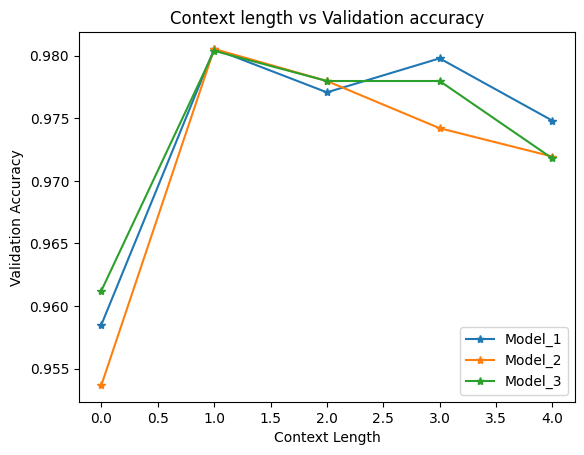

In [ ]:
import matplotlib.pyplot as plt
for model in model_performance:
  context_size = []
  val_accuracy = []
  for c_len in model_performance[model]:
    context_size.append(int(c_len))
    val_accuracy.append(model_performance[model][c_len]['val_accuracy'])
  plt.plot(context_size, val_accuracy, marker='*',label=model)
plt.xlabel('Context Length')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Context length vs Validation accuracy')
plt.savefig('/content/drive/MyDrive/NLP_Assignment_2/Plots/FFNN.png')
plt.show()


In [ ]:
import pickle
file_path = '/content/drive/MyDrive/NLP_Assignment_2/model_performace_ffnn.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(model_performance, f)

file_path = '/content/drive/MyDrive/NLP_Assignment_2/ffnn_vocab.pkl'
with open(file_path, 'wb') as f:
    pickle.dump([dataset_train.vocabulary_words, dataset_train.vocabulary_tags],  f)

# Testing the best Model (LSTM and FFNN)
## FFNN
Model_1 with context size 1 showed best performance on dev set and considered as best FFNN model
## LSTM
Model_3 showed best performance on dev set and considered as best LSTM model

FFNN Testing
Utilising cpu
Dev set classification report
              precision    recall  f1-score   support

       PROPN       0.98      0.99      0.99      1551
         ADP       0.99      0.99      0.99      1414
        NOUN       0.98      0.99      0.98      1137
        VERB       0.98      0.98      0.98       653
         DET       0.99      0.96      0.97       567
        PRON       0.97      0.99      0.98       413
         AUX       1.00      0.96      0.98       264
         ADJ       0.97      0.88      0.92       226
         NUM       0.99      0.95      0.97       131
       CCONJ       1.00      1.00      1.00       107
         ADV       0.79      0.85      0.82        59
        PART       0.91      1.00      0.95        73
        INTJ       1.00      1.00      1.00        35

    accuracy                           0.98      6630
   macro avg       0.97      0.96      0.96      6630
weighted avg       0.98      0.98      0.98      6630



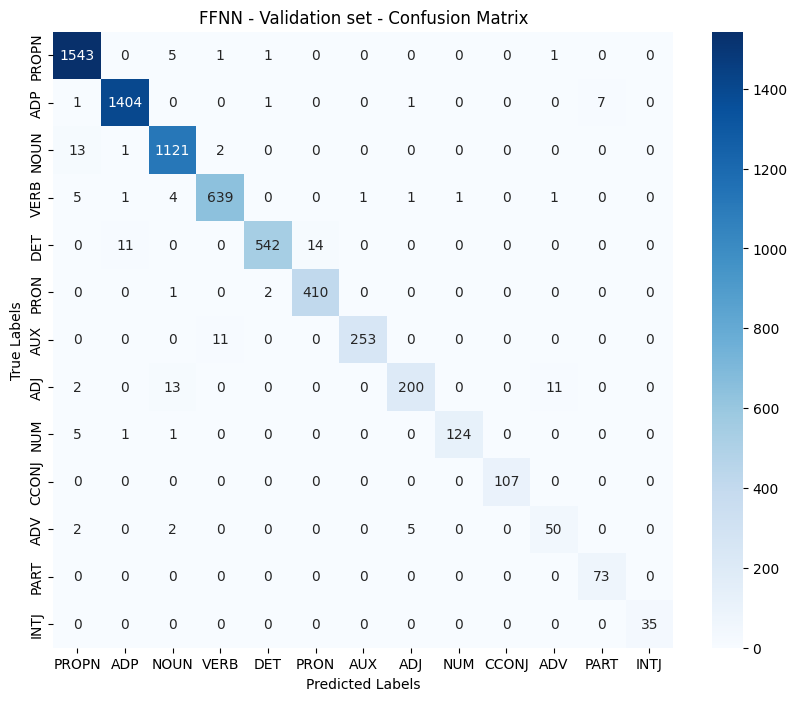

Test set classification report
              precision    recall  f1-score   support

       PROPN       0.98      0.99      0.99      1567
         ADP       1.00      0.99      1.00      1434
        NOUN       0.99      0.99      0.99      1166
        VERB       0.99      0.97      0.98       629
         DET       0.99      0.99      0.99       512
        PRON       0.99      0.99      0.99       392
         AUX       0.98      0.99      0.99       256
         ADJ       0.94      0.95      0.95       220
         NUM       0.91      0.83      0.87       127
       CCONJ       1.00      0.99      1.00       109
         ADV       0.85      0.72      0.78        76
        PART       0.95      1.00      0.97        56
        INTJ       0.97      1.00      0.99        36

    accuracy                           0.98      6580
   macro avg       0.96      0.96      0.96      6580
weighted avg       0.98      0.98      0.98      6580



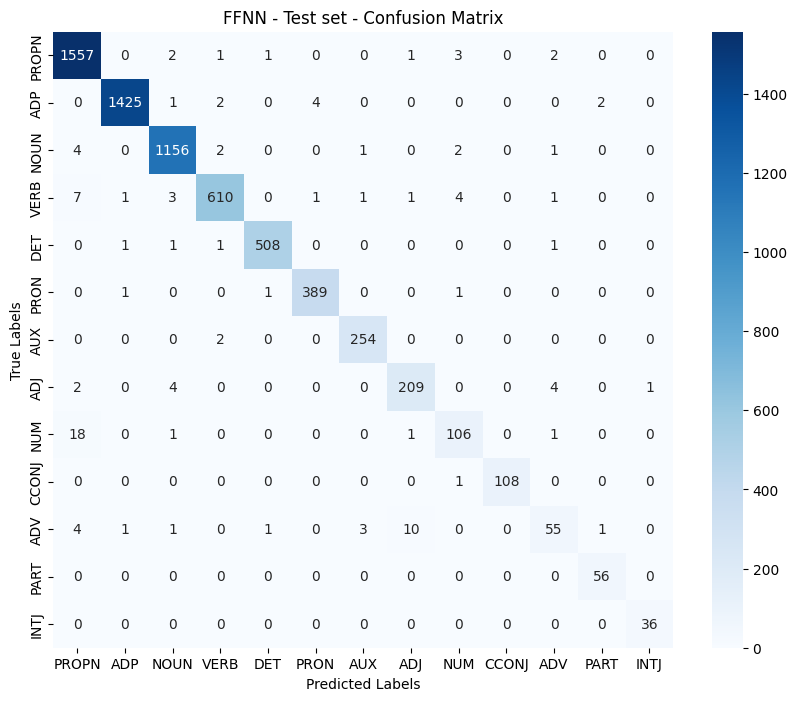

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("FFNN Testing")
model_name = 'Model_1'
hidden_dim = model_configs_fnn[model_name]['hidden_dims']
activation = model_configs_fnn[model_name]['activation']
embedding_dim = model_configs_fnn[model_name]['embedding_size']
p,s = 1,1
context_size = (p*2)+1
dataset_train = FFNNDataset(data['train'],p=p,s=s)
dataset_eval = FFNNDataset(data['dev'],p=p,s=s, vocabulary_words=dataset_train.vocabulary_words, vocabulary_tags=dataset_train.vocabulary_tags)
dataset_test = FFNNDataset(data['test'],p=p,s=s, vocabulary_words=dataset_train.vocabulary_words, vocabulary_tags=dataset_train.vocabulary_tags)
# Dataloader
val_dataloader = DataLoader(dataset_eval, batch_size=64)
test_dataloader = DataLoader(dataset_test, batch_size=64)
sorted_vocab_mapping = {v: k for k, v in sorted(dataset_train.vocabulary_tags.get_stoi().items(), key=lambda item: item[1]) if k != '<pad>'}

model = FFNN(len(dataset_train.vocabulary_words), len(dataset_train.vocabulary_tags), context_size,
                 hidden_dim, activation, embedding_dim=embedding_dim)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Utilising",device)
model = model.to(device)
model_path = '/content/drive/MyDrive/NLP_Assignment_2/Models/'+model_name+'_'+str(p)+".pt"
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

with torch.no_grad():
    all_predictions = []
    all_ground_truth = []
    for batch_num, (words, tags) in enumerate(val_dataloader):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        predictions = torch.argmax(pred, dim=-1).cpu().numpy()
        ground_truth = tags.cpu().numpy()
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
    all_predictions = np.concatenate(all_predictions)
    all_ground_truth = np.concatenate(all_ground_truth)
    accuracy_val = accuracy_score(all_ground_truth, all_predictions)

    print("Dev set classification report")
    report = classification_report(all_ground_truth, all_predictions, labels=list(sorted_vocab_mapping.keys()), target_names=sorted_vocab_mapping.values())
    print(report)
    conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_vocab_mapping.values(), yticklabels=sorted_vocab_mapping.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('FFNN - Validation set - Confusion Matrix')
    plt.savefig('/content/drive/MyDrive/NLP_Assignment_2/Plots/FFNN_val_cm.png')
    plt.show()

    all_predictions = []
    all_ground_truth = []
    for batch_num, (words, tags) in enumerate(test_dataloader):
        (words, tags) = (words.to(device), tags.to(device))
        pred = model(words)
        predictions = torch.argmax(pred, dim=-1).cpu().numpy()
        ground_truth = tags.cpu().numpy()
        all_predictions.append(predictions)
        all_ground_truth.append(ground_truth)
    all_predictions = np.concatenate(all_predictions)
    all_ground_truth = np.concatenate(all_ground_truth)
    accuracy_test = accuracy_score(all_ground_truth, all_predictions)
    print("Test set classification report")
    report = classification_report(all_ground_truth, all_predictions, target_names=sorted_vocab_mapping.values())
    print(report)

    conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_vocab_mapping.values(), yticklabels=sorted_vocab_mapping.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('FFNN - Test set - Confusion Matrix')
    plt.savefig('/content/drive/MyDrive/NLP_Assignment_2/Plots/FFNN_test_cm.png')
    plt.show()

LSTM Model testing
Utilising cpu
Dev set classification report
              precision    recall  f1-score   support

       PROPN       0.99      0.99      0.99      1551
         ADP       0.99      0.99      0.99      1414
        NOUN       0.98      0.98      0.98      1137
        VERB       0.97      0.99      0.98       653
         DET       0.99      0.96      0.97       567
        PRON       0.96      1.00      0.98       413
         AUX       0.99      0.96      0.97       264
         ADJ       0.98      0.89      0.93       226
         NUM       0.96      0.98      0.97       131
       CCONJ       1.00      1.00      1.00       107
         ADV       0.85      0.85      0.85        59
        PART       0.90      0.97      0.93        73
        INTJ       1.00      0.97      0.99        35

    accuracy                           0.98      6630
   macro avg       0.97      0.96      0.97      6630
weighted avg       0.98      0.98      0.98      6630



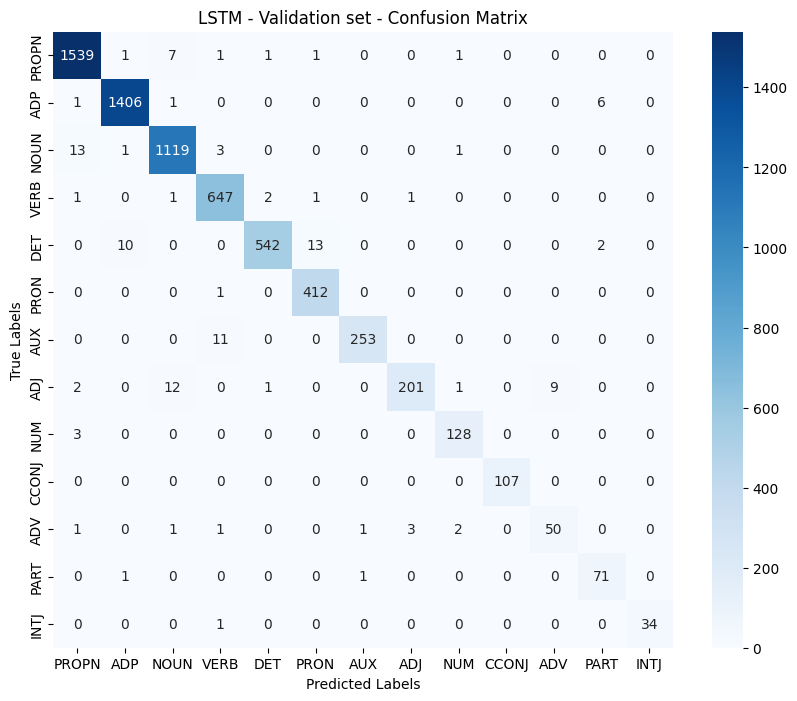

Test set classification report
              precision    recall  f1-score   support

       PROPN       0.98      1.00      0.99      1567
         ADP       1.00      1.00      1.00      1434
        NOUN       0.99      0.99      0.99      1166
        VERB       0.99      0.99      0.99       629
         DET       0.99      0.99      0.99       512
        PRON       0.98      1.00      0.99       392
         AUX       1.00      0.99      0.99       256
         ADJ       0.96      0.95      0.95       220
         NUM       0.97      0.92      0.94       127
       CCONJ       1.00      1.00      1.00       109
         ADV       0.90      0.79      0.84        76
        PART       0.97      1.00      0.98        56
        INTJ       1.00      0.97      0.99        36

    accuracy                           0.99      6580
   macro avg       0.98      0.97      0.97      6580
weighted avg       0.99      0.99      0.99      6580



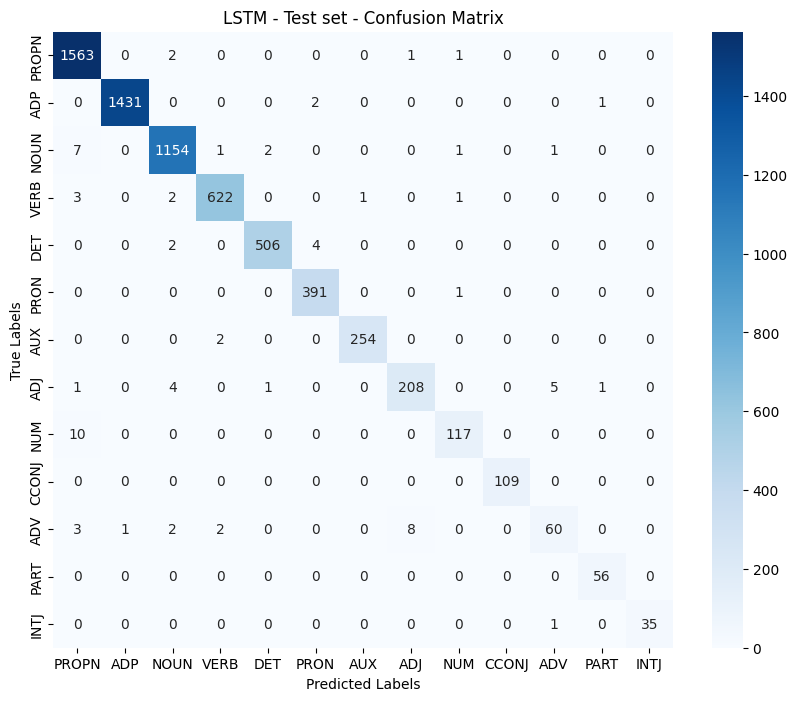

In [13]:
from sklearn.metrics import classification_report

print("LSTM Model testing")
model_name = 'model_3'
hidden_dim = model_configs_lstm[model_name]['hidden_dim']
hidden_layers = model_configs_lstm[model_name]['hidden_layers']
embedding_dim = model_configs_lstm[model_name]['embedding_size']
bidirectionality = model_configs_lstm[model_name]['bidirectionality']

dataset_train = LSTMDataset(data['train'])
dataset_eval = LSTMDataset(data['dev'], vocabulary_words=dataset_train.vocabulary_words, vocabulary_tags=dataset_train.vocabulary_tags)
dataset_test = LSTMDataset(data['test'],vocabulary_words=dataset_train.vocabulary_words, vocabulary_tags=dataset_train.vocabulary_tags)
sorted_vocab_mapping = {v: k for k, v in sorted(dataset_train.vocabulary_tags.get_stoi().items(), key=lambda item: item[1]) if k != '<pad>'}

val_dataloader = DataLoader(dataset_eval, batch_size=64, collate_fn=dataset_eval.collate)
test_dataloader = DataLoader(dataset_test, batch_size=64, collate_fn=dataset_eval.collate)
model = LSTMModel(len(dataset_train.vocabulary_words), len(dataset_train.vocabulary_tags), hidden_dim, hidden_layers,bidirectionality=bidirectionality, embedding_dim=embedding_dim)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Utilising",device)
model = model.to(device)
model_path = '/content/drive/MyDrive/NLP_Assignment_2/Models/LSTM_'+model_name+".pt"
state_dict = torch.load(model_path,map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

with torch.no_grad():
  all_predictions = []
  all_ground_truth = []
  for batch_num, (words, tags) in enumerate(val_dataloader):
      (words, tags) = (words.to(device), tags.to(device))
      pred = model(words)
      predictions = torch.argmax(pred, axis=-1).cpu().numpy().flatten()
      ground_truth = tags.cpu().numpy().flatten()
      all_predictions.append(predictions)
      all_ground_truth.append(ground_truth)
  all_predictions = np.concatenate(all_predictions)
  all_ground_truth = np.concatenate(all_ground_truth)

  non_pad_indices = (all_ground_truth != dataset_train.vocabulary_tags[PAD_TOKEN])
  all_predictions = all_predictions[non_pad_indices]
  all_ground_truth = all_ground_truth[non_pad_indices]

  print("Dev set classification report")
  report = classification_report(all_ground_truth, all_predictions, labels=list(sorted_vocab_mapping.keys()), target_names=sorted_vocab_mapping.values())
  print(report)

  conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_vocab_mapping.values(), yticklabels=sorted_vocab_mapping.values())
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('LSTM - Validation set - Confusion Matrix')
  plt.savefig('/content/drive/MyDrive/NLP_Assignment_2/Plots/lstm_val_cm.png')
  plt.show()

  all_predictions = []
  all_ground_truth = []
  for batch_num, (words, tags) in enumerate(test_dataloader):
      (words, tags) = (words.to(device), tags.to(device))
      pred = model(words)
      predictions = torch.argmax(pred, axis=-1).cpu().numpy().flatten()
      ground_truth = tags.cpu().numpy().flatten()
      all_predictions.append(predictions)
      all_ground_truth.append(ground_truth)
  all_predictions = np.concatenate(all_predictions)
  all_ground_truth = np.concatenate(all_ground_truth)

  non_pad_indices = (all_ground_truth != dataset_train.vocabulary_tags[PAD_TOKEN])
  all_predictions = all_predictions[non_pad_indices]
  all_ground_truth = all_ground_truth[non_pad_indices]
  print("Test set classification report")
  report = classification_report(all_ground_truth, all_predictions, labels=list(sorted_vocab_mapping.keys()), target_names=sorted_vocab_mapping.values())
  print(report)

  conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_vocab_mapping.values(), yticklabels=sorted_vocab_mapping.values())
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('LSTM - Test set - Confusion Matrix')
  plt.savefig('/content/drive/MyDrive/NLP_Assignment_2/Plots/lstm_test_cm.png')
  plt.show()
